In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images, [label] * len(images)

In [3]:
data_dir = 'dataset'
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

all_images = []
all_labels = []
for folder in folders:
    images, label_list = load_images_from_folder(os.path.join(data_dir, folder), labels[folder])
    all_images.extend(images)
    all_labels.extend(label_list)

all_images = np.array(all_images).reshape(-1, 128, 128, 1) / 255.0
all_labels = to_categorical(all_labels, num_classes=4)

data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    zoom_range=0.05,         
    horizontal_flip=True,   
    fill_mode='nearest'
)

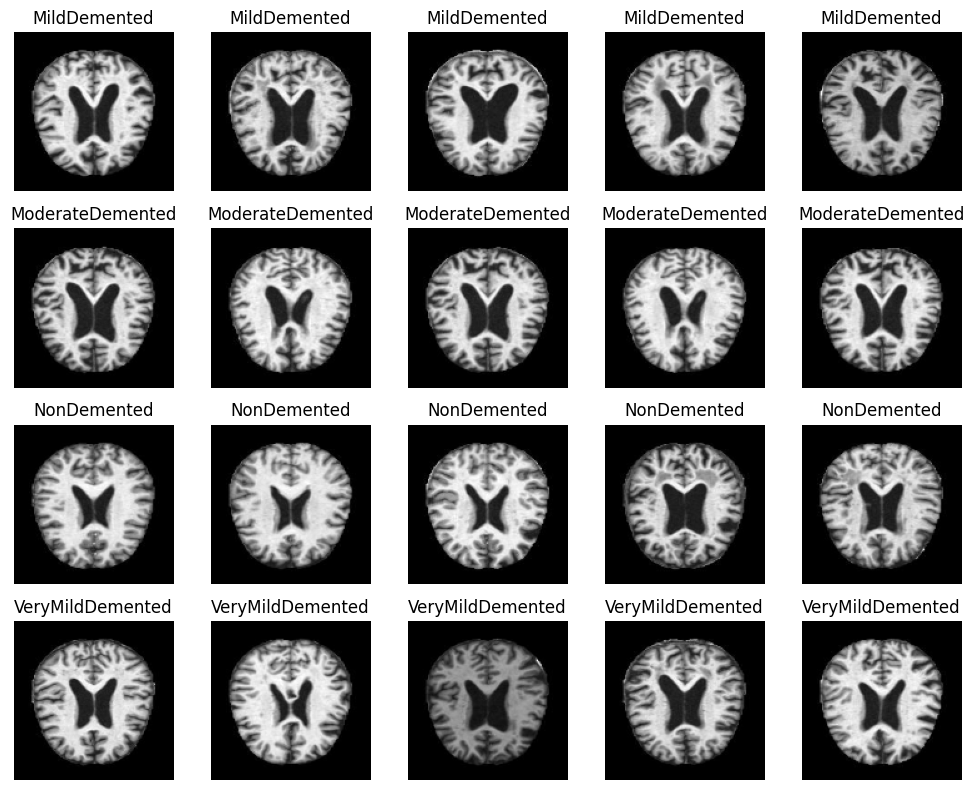

In [4]:
def display_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_images, figsize=(10, 2 * len(class_names)))
    for i, class_name in enumerate(class_names):
        class_images = [img for img, label in zip(images, labels) if np.argmax(label) == i]
        for j in range(num_images):
            if j < len(class_images):
                ax = axes[i, j]
                ax.imshow(class_images[j].squeeze(), cmap='gray')
                ax.set_title(class_name)
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
display_images(all_images, all_labels, class_names, num_images=5)


In [6]:
fold_results = {
    'accuracy': [],
    'loss': [],
    'confusion_matrices': [],
    'history': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f'Training for fold {fold_no}...')
    history = model.fit(
        train_generator,
        epochs=150, 
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train) // 32
    )
    fold_results['history'].append(history)

    scores = model.evaluate(X_val, y_val, verbose=0)
    fold_results['accuracy'].append(scores[1])
    fold_results['loss'].append(scores[0])

    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    fold_results['confusion_matrices'].append(cm)

    print(f'Confusion Matrix for fold {fold_no}:')
    print(cm)

    fold_no += 1




Training for fold 1...
Epoch 1/150
160/160 [==============================] - 27s 166ms/step - loss: 1.0506 - accuracy: 0.4875 - val_loss: 0.9909 - val_accuracy: 0.5039
Epoch 2/150
160/160 [==============================] - 26s 164ms/step - loss: 0.9583 - accuracy: 0.5418 - val_loss: 0.9497 - val_accuracy: 0.5297
Epoch 3/150
160/160 [==============================] - 26s 162ms/step - loss: 0.9210 - accuracy: 0.5561 - val_loss: 0.9589 - val_accuracy: 0.5336
Epoch 4/150
160/160 [==============================] - 26s 165ms/step - loss: 0.9126 - accuracy: 0.5609 - val_loss: 0.8845 - val_accuracy: 0.5633
Epoch 5/150
160/160 [==============================] - 26s 163ms/step - loss: 0.8830 - accuracy: 0.5746 - val_loss: 0.8871 - val_accuracy: 0.5703
Epoch 6/150
160/160 [==============================] - 26s 164ms/step - loss: 0.8826 - accuracy: 0.5758 - val_loss: 0.9168 - val_accuracy: 0.5836
Epoch 7/150
160/160 [==============================] - 27s 169ms/step - loss: 0.8643 - accuracy: 0.58

In [7]:
print("\nCross-Validation Results Summary:")
avg_accuracy = np.mean(fold_results['accuracy'])
avg_loss = np.mean(fold_results['loss'])
print(f"Average Accuracy: {avg_accuracy*100:.2f}%")
print(f"Average Loss: {avg_loss:.4f}")


Cross-Validation Results Summary:
Average Accuracy: 96.33%
Average Loss: 0.1195


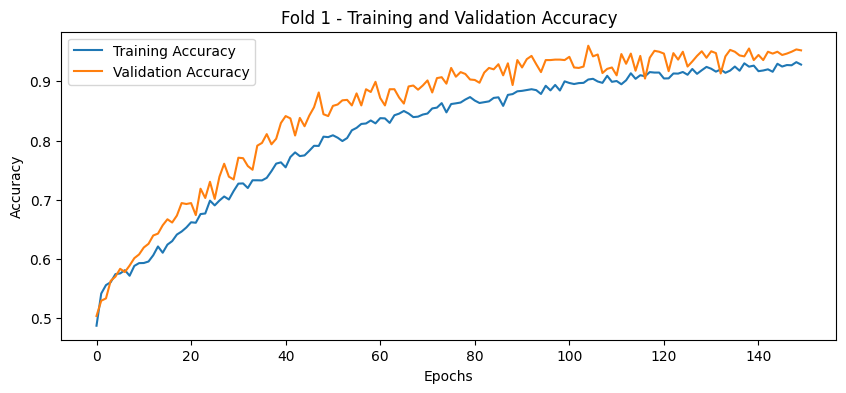

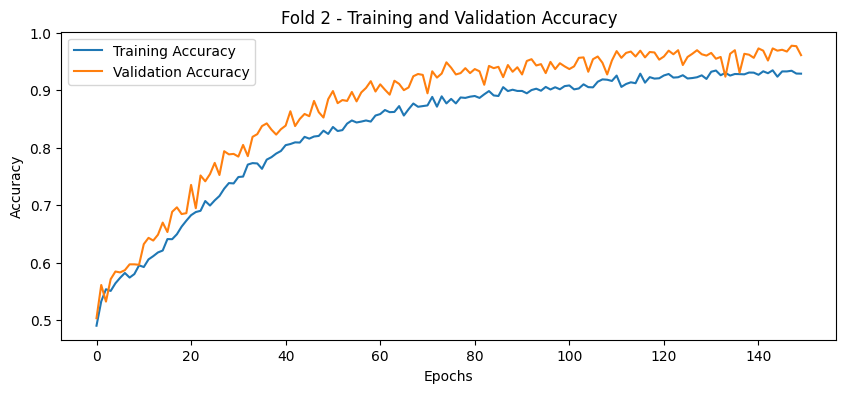

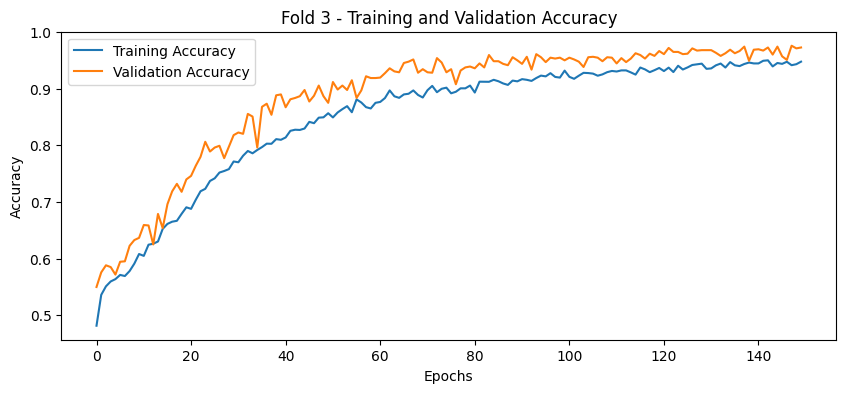

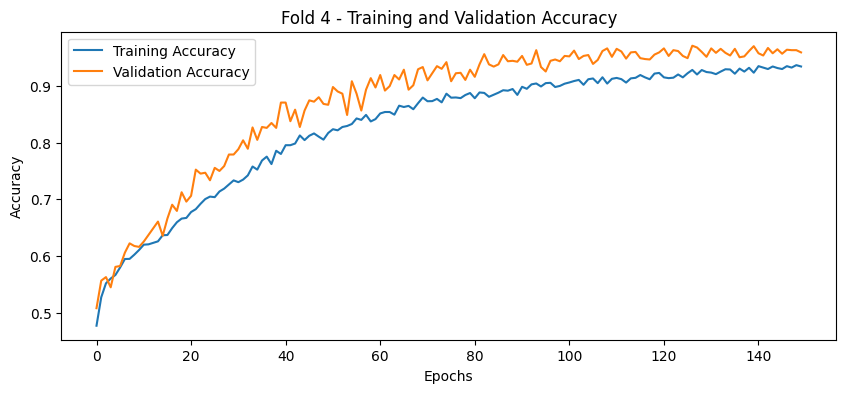

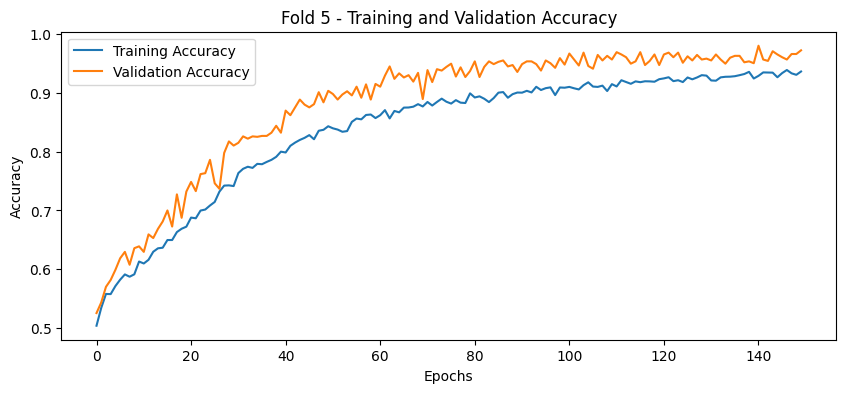

In [8]:
for i, history in enumerate(fold_results['history'], 1):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


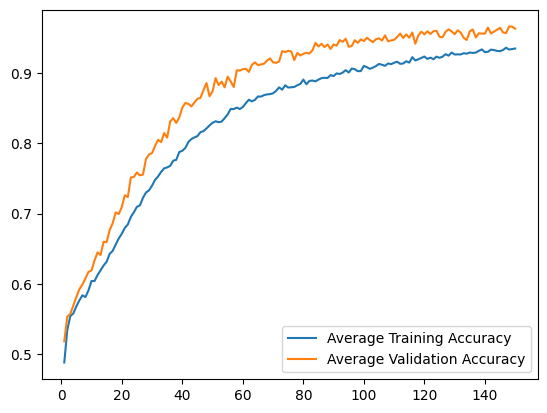

In [9]:
avg_train_acc = np.mean([h.history['accuracy'] for h in fold_results['history']], axis=0)
avg_val_acc = np.mean([h.history['val_accuracy'] for h in fold_results['history']], axis=0)

epochs = range(1, len(avg_train_acc) + 1)
plt.plot(epochs, avg_train_acc, label='Average Training Accuracy')
plt.plot(epochs, avg_val_acc, label='Average Validation Accuracy')
plt.legend()
plt.show()

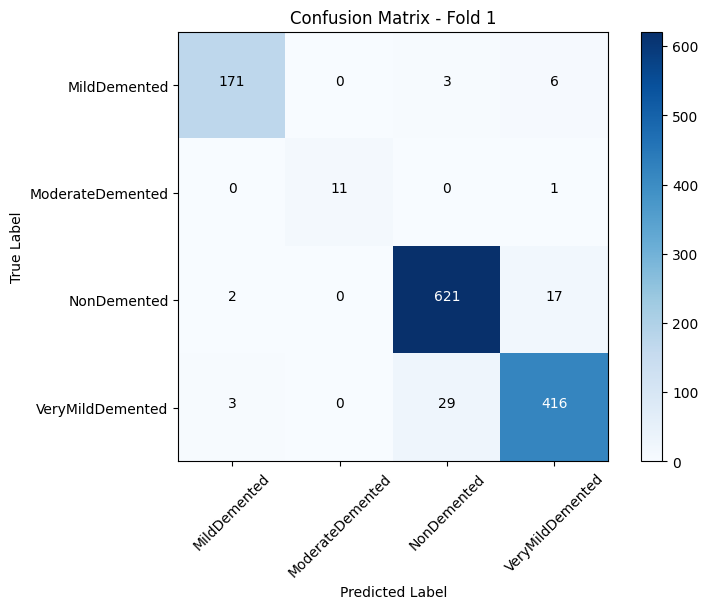

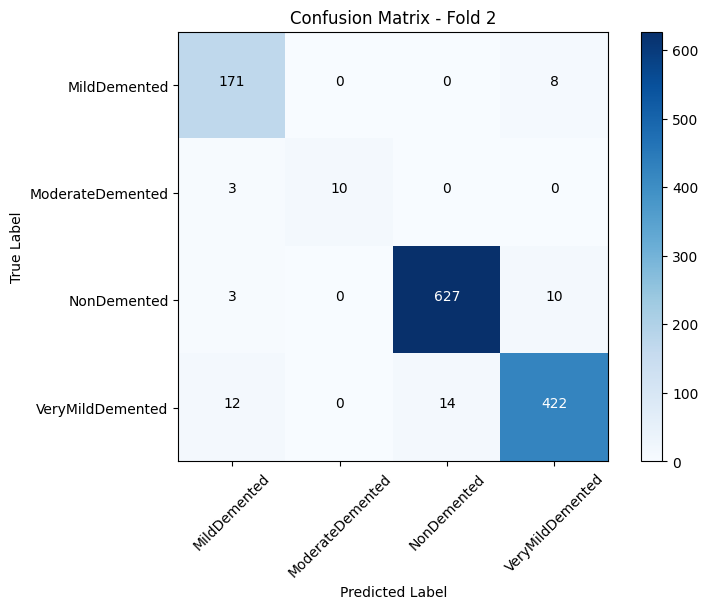

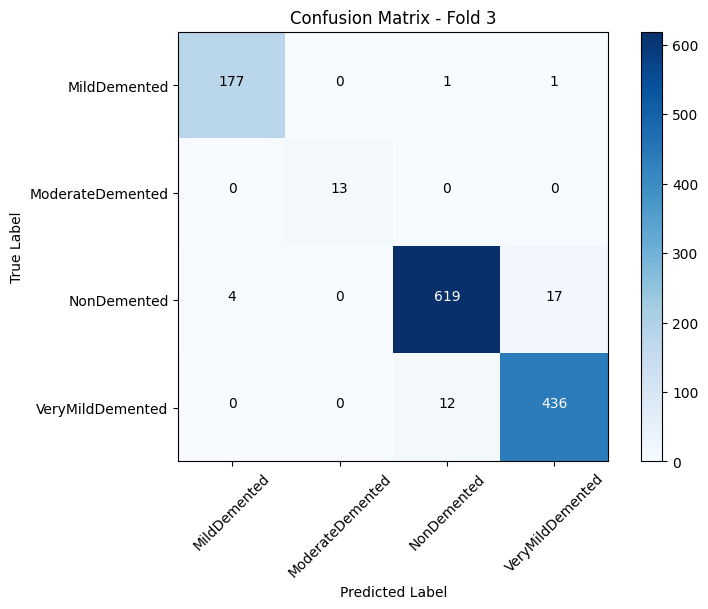

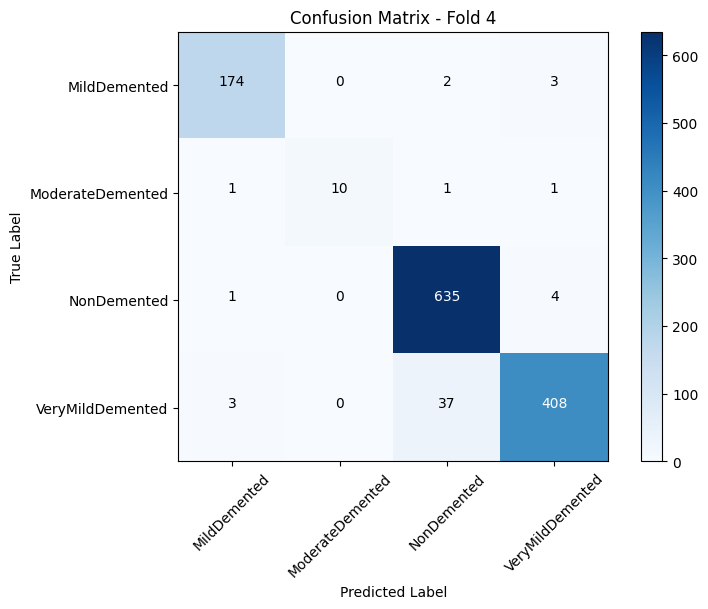

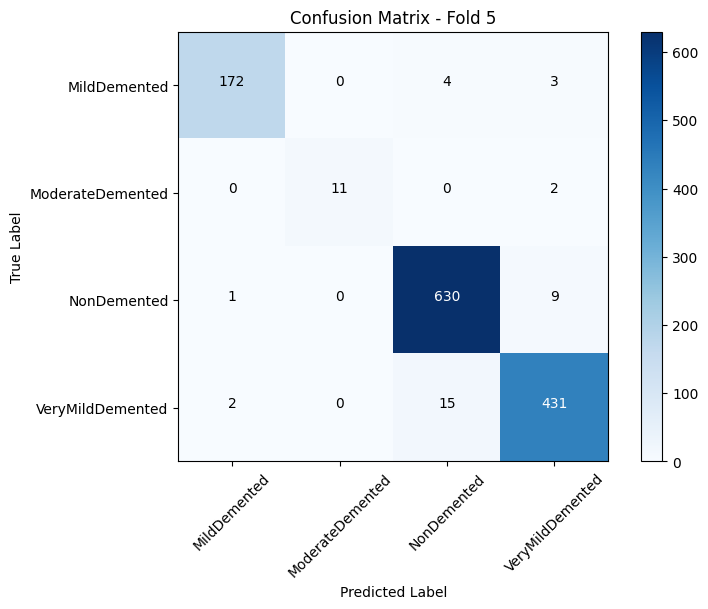

In [10]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = folders
for i, cm in enumerate(fold_results['confusion_matrices'], 1):
    plot_confusion_matrix(cm, class_names, title=f'Confusion Matrix - Fold {i}')
